<a href="https://colab.research.google.com/github/myers1091/UmpqQuant_GroupLearningSeminar/blob/main/hnorem/session06/ch_14_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.train import Feature, Features, Example, BytesList, FloatList, Int64List
import matplotlib.pyplot as plt

import re
import shutil
import string

from tensorflow.keras import utils
import collections
import pathlib


## Exercise 10

Exercise: Use transfer learning for large image classification, going through these steps:

* Create a training set containing at least 100 images per class. For example, you could classify your own pictures based on the location (beach, mountain, city, etc.), or alternatively you can use an existing dataset (e.g., from TensorFlow Datasets).
* Split it into a training set, a validation set, and a test set.
* Build the input pipeline, including the appropriate preprocessing operations, and optionally add data augmentation.
* Fine-tune a pretrained model on this dataset.

I personally ran out of time so I just followed their example.

In [3]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to ~/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [4]:
class_names = info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [5]:
n_classes = info.features["label"].num_classes

In [6]:
dataset_size = info.splits["train"].num_examples
dataset_size

3670

In [7]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

(240, 240, 3)
(375, 500, 3)
(334, 500, 3)
(240, 207, 3)
(265, 500, 3)
(240, 320, 3)
(212, 320, 3)
(333, 500, 3)
(240, 320, 3)


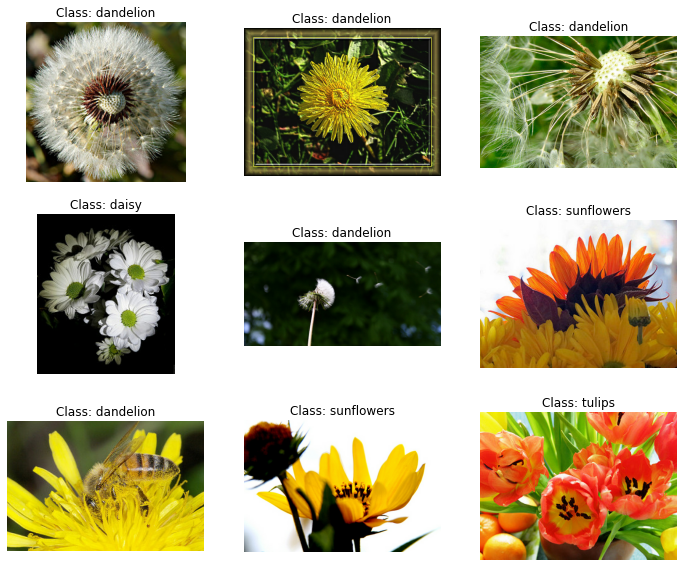

In [8]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    print(image.shape)
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

I notice above that the input images are different sizes! Yikes!

In [9]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

The step above makes all of the images the same size, which is good!

This applies the preprocessing function from xception, a fancy pre-trained model. Output pixels are from -1 to 1 (hence shift later).

In [10]:
batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

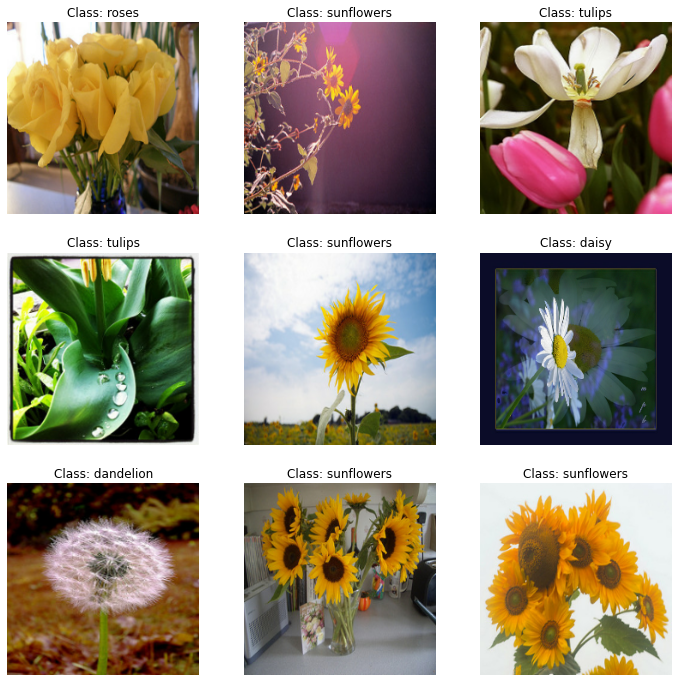

In [11]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

The "include_top" code below removes the dense layer at the top of xception, which is specific to that application. We then add our own.

In [12]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

83683744/83683744 [==============================] - 0s 0us/step


Here is a list of the layers in base_model:

In [13]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_1
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_2
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepconv3_act

In [14]:
for layer in base_model.layers:
    layer.trainable = False

I tried once without setting runtime to GPU and wow, was it slow!

In [15]:
optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
86/86 [==============================] - 25s 159ms/step - loss: 1.6781 - accuracy: 0.7812 - val_loss: 1.3895 - val_accuracy: 0.8493
Epoch 2/5
86/86 [==============================] - 13s 153ms/step - loss: 0.4813 - accuracy: 0.9153 - val_loss: 0.8016 - val_accuracy: 0.8621
Epoch 3/5
86/86 [==============================] - 14s 158ms/step - loss: 0.2196 - accuracy: 0.9528 - val_loss: 0.8030 - val_accuracy: 0.8511
Epoch 4/5
86/86 [==============================] - 14s 165ms/step - loss: 0.1355 - accuracy: 0.9644 - val_loss: 0.7481 - val_accuracy: 0.8750
Epoch 5/5
86/86 [==============================] - 14s 161ms/step - loss: 0.0912 - accuracy: 0.9735 - val_loss: 0.7461 - val_accuracy: 0.8713


In [ ]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)

Epoch 1/40
86/86 [==============================] - 64s 656ms/step - loss: 0.3575 - accuracy: 0.8783 - val_loss: 0.5018 - val_accuracy: 0.8934
Epoch 2/40
86/86 [==============================] - 54s 628ms/step - loss: 0.0764 - accuracy: 0.9760 - val_loss: 0.3206 - val_accuracy: 0.9099
Epoch 3/40
86/86 [==============================] - 54s 633ms/step - loss: 0.0370 - accuracy: 0.9880 - val_loss: 0.3148 - val_accuracy: 0.9081
Epoch 4/40
86/86 [==============================] - 54s 633ms/step - loss: 0.0201 - accuracy: 0.9953 - val_loss: 0.3154 - val_accuracy: 0.9191
Epoch 5/40
86/86 [==============================] - 54s 631ms/step - loss: 0.0089 - accuracy: 0.9978 - val_loss: 0.2528 - val_accuracy: 0.9283
Epoch 6/40
86/86 [==============================] - 55s 637ms/step - loss: 0.0074 - accuracy: 0.9978 - val_loss: 0.2508 - val_accuracy: 0.9191
Epoch 7/40
86/86 [==============================] - 55s 639ms/step - loss: 0.0062 - accuracy: 0.9978 - val_loss: 0.2511 - val_accuracy: 0.9283